In [1]:
import pathlib
import json
import os

In [2]:
path=pathlib.Path('../data/raw/via_2.0.8/via_powder_particle_masks.json')
path.parent

PosixPath('../data/raw/via_2.0.8')

In [3]:
with open('../data/raw/via_2.0.8/via_powder_particle_masks.json', 'rb') as f:
    data = json.load(f)
root = data['_via_settings']['core']['default_filepath']

In [4]:
import skimage.io
import numpy as np
import json
from detectron2.structures import BoxMode

def get_data_dicts(json_path):
    """
    Loads data in format consistent with detectron2.
    Adapted from balloon example here:
    https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
    
    Inputs: 
      json_path: string or pathlib path to json file containing relevant annotations
    
    Outputs:
      dataset_dicts: list(dic) of datasets compatible for detectron 2
                     More information can be found at:
                     https://detectron2.readthedocs.io/tutorials/datasets.html#
    """
    json_path = pathlib.Path(json_path) # needed for path manipulations
    with open(json_path) as f:
        via_data = json.load(f)
        
    # root directory of images is given by relative path in json file
    img_root = pathlib.Path(json_path.parent, via_data['_via_settings']['core']['default_filepath'])
    imgs_anns = via_data['_via_img_metadata']
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = pathlib.Path(img_root, v["filename"])
        height, width = skimage.io.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for anno in annos:
            # not sure why this was here, commenting it out didn't seem to break anything
            #assert not anno["region_attributes"] 
            anno = anno["shape_attributes"]
            
            # polygon masks is list of polygon coordinates in format ([x0,y0,x1,y1...xn,yn]) as specified in
            # https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.PolygonMasks
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS, # boxes are given in absolute coordinates (ie not corner+width+height)
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_data_dicts("../data/raw/via_2.0.8/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [12]:
cv2.imread(str(d['file_name'])).shape

(1024, 1536, 3)

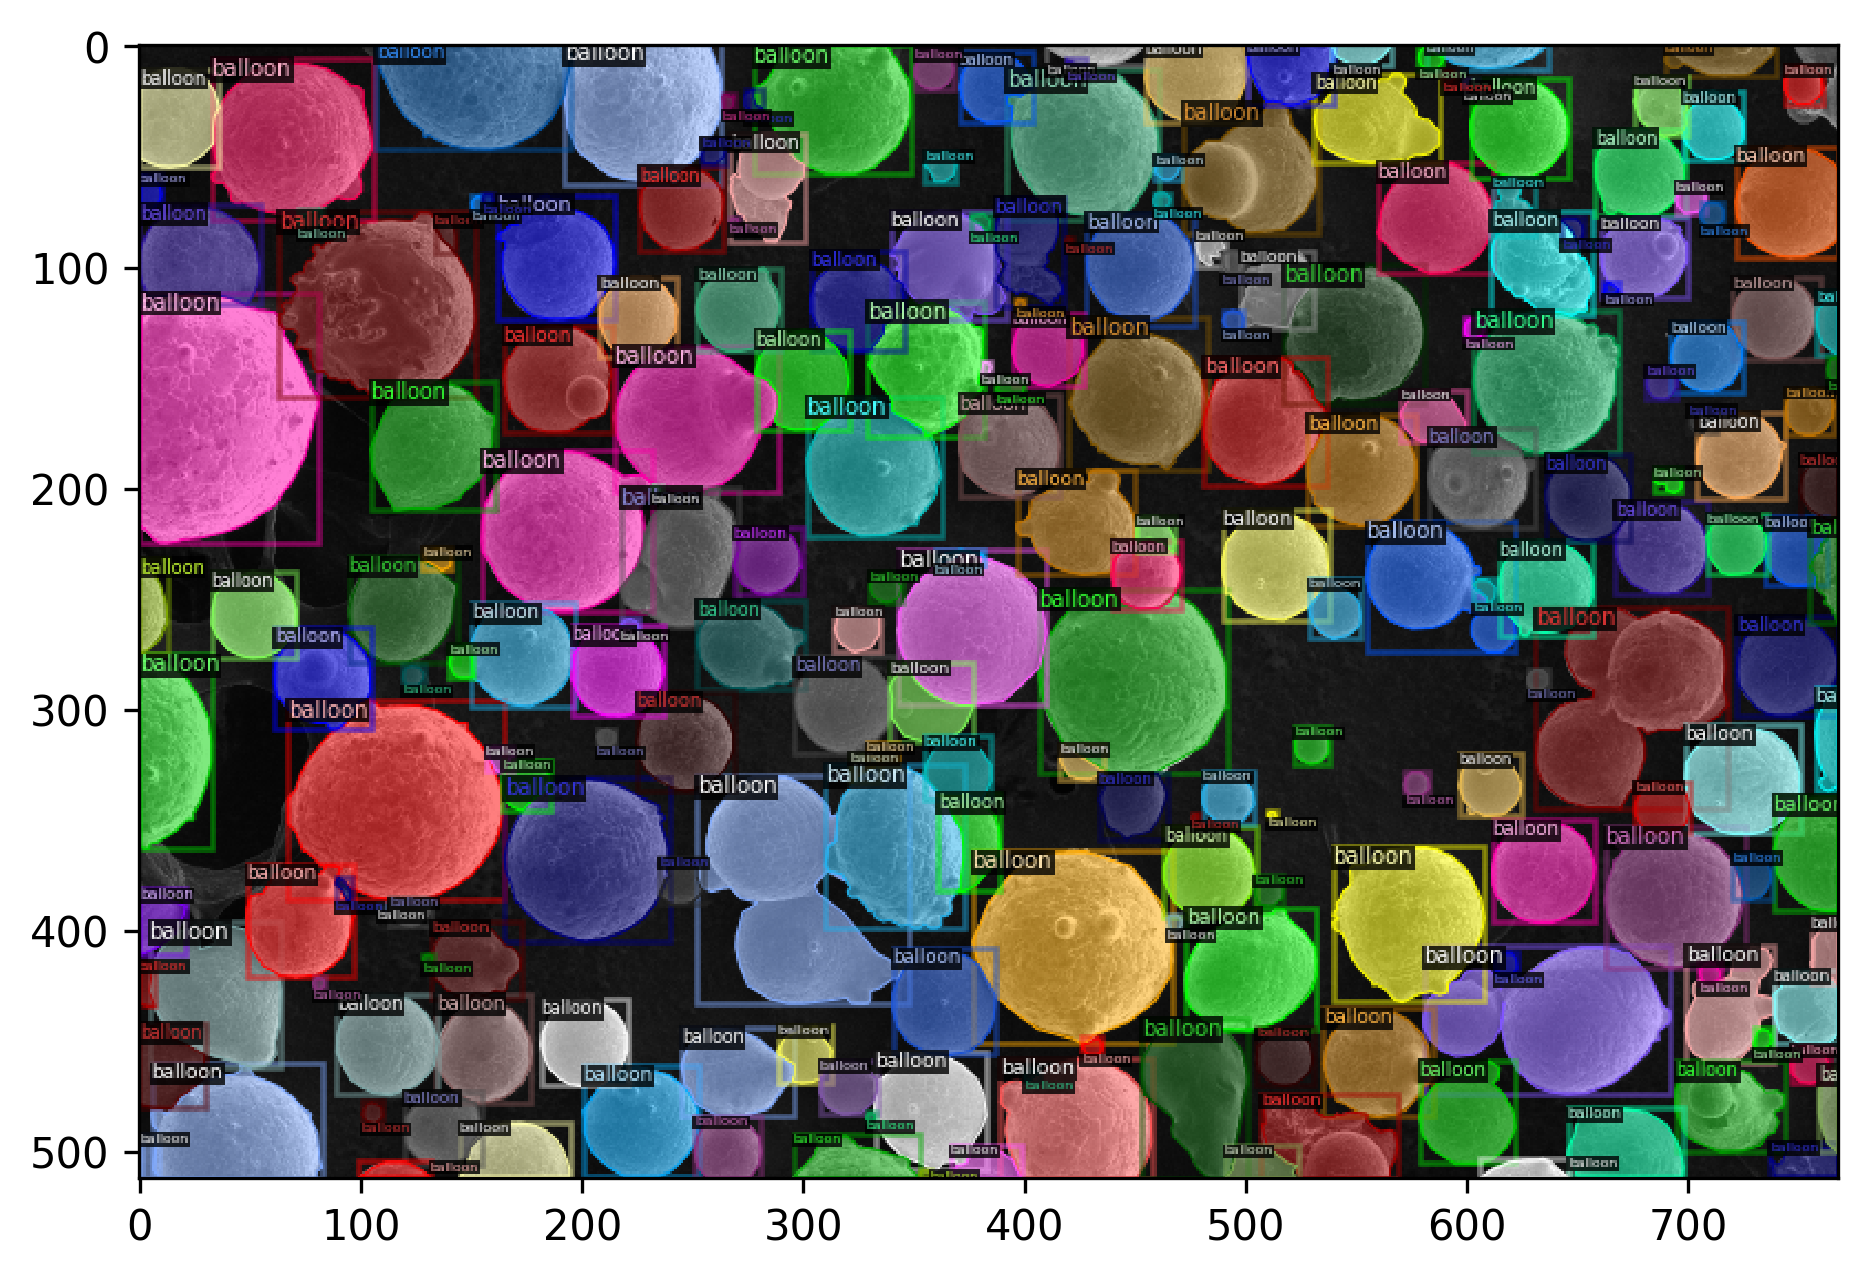

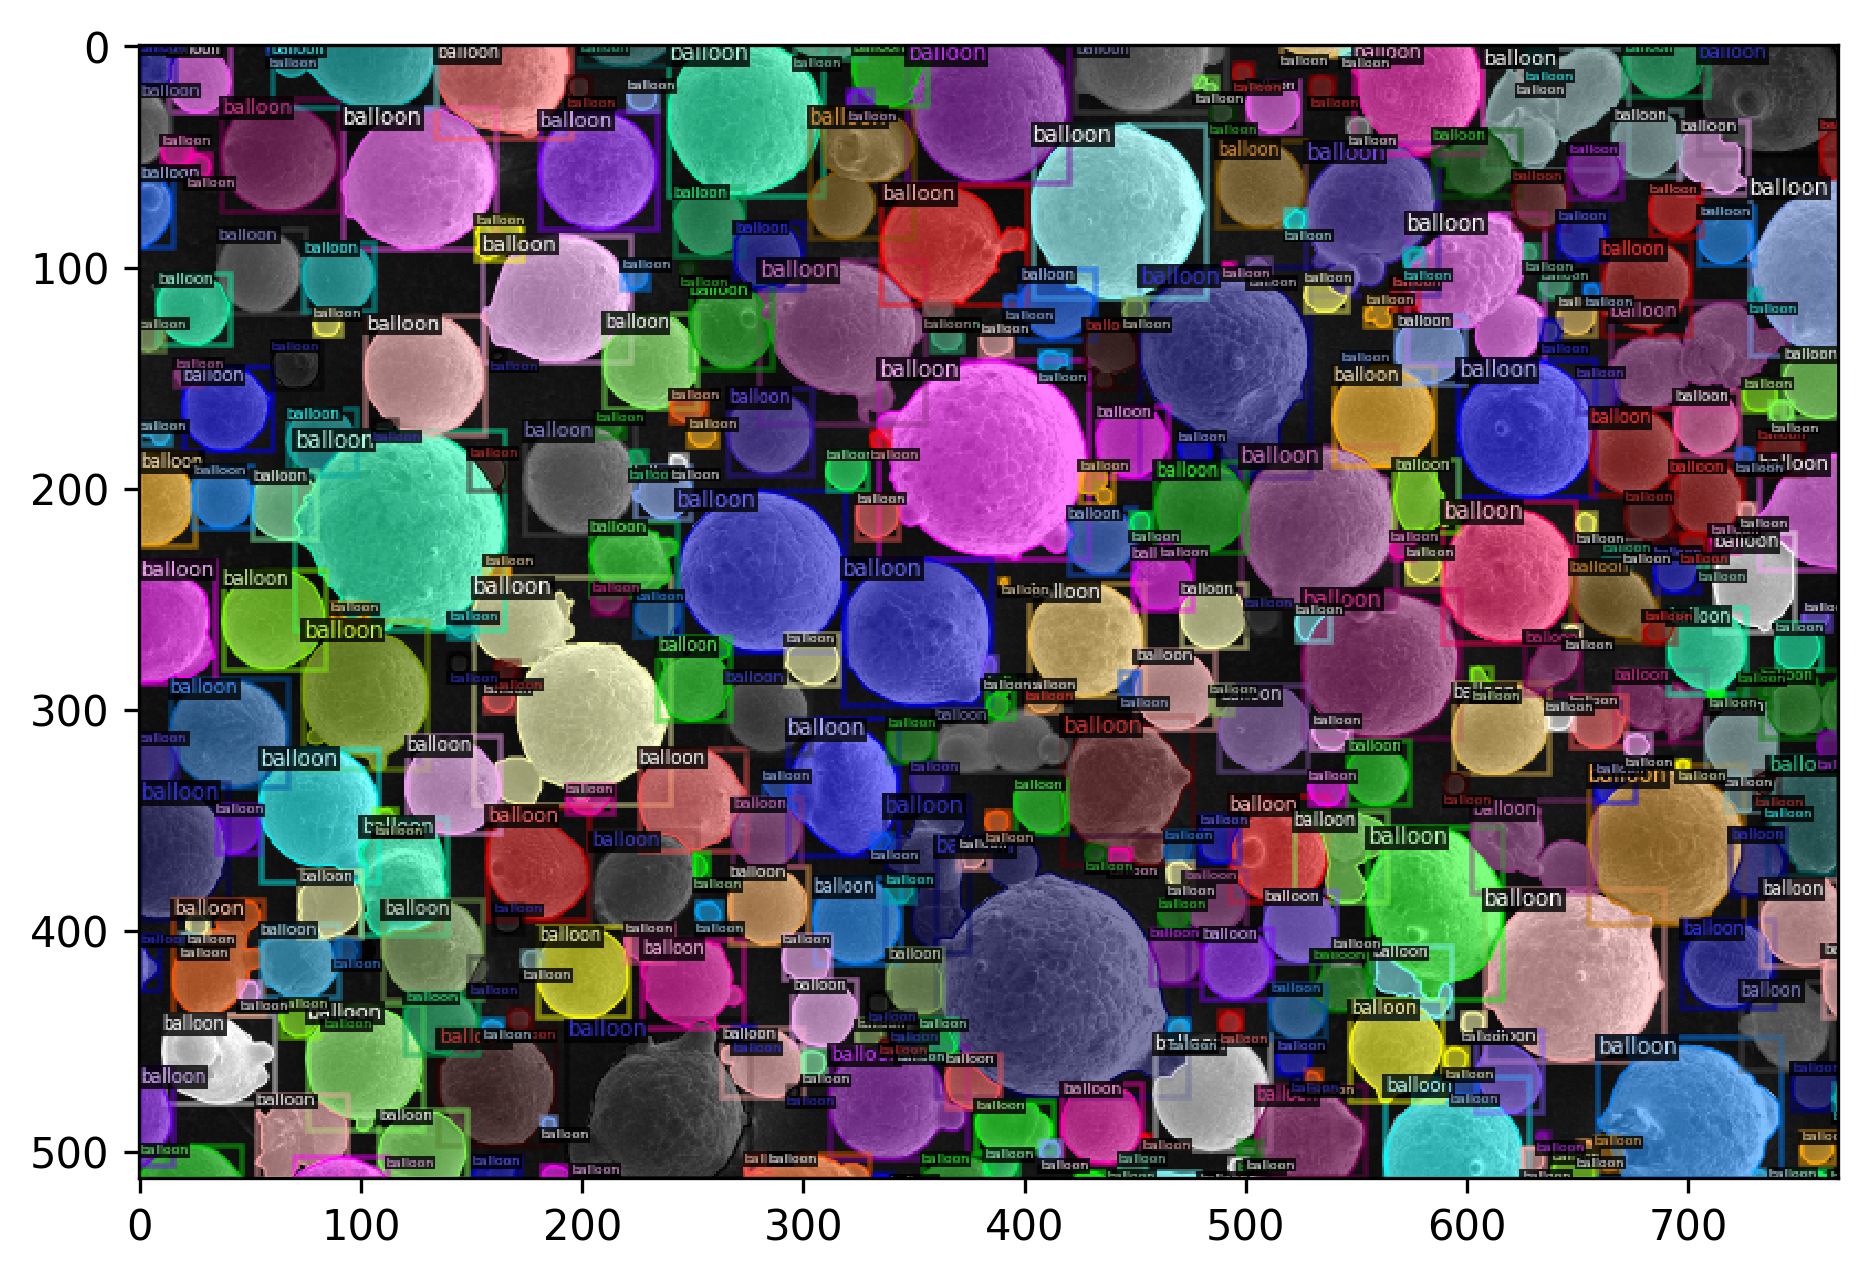

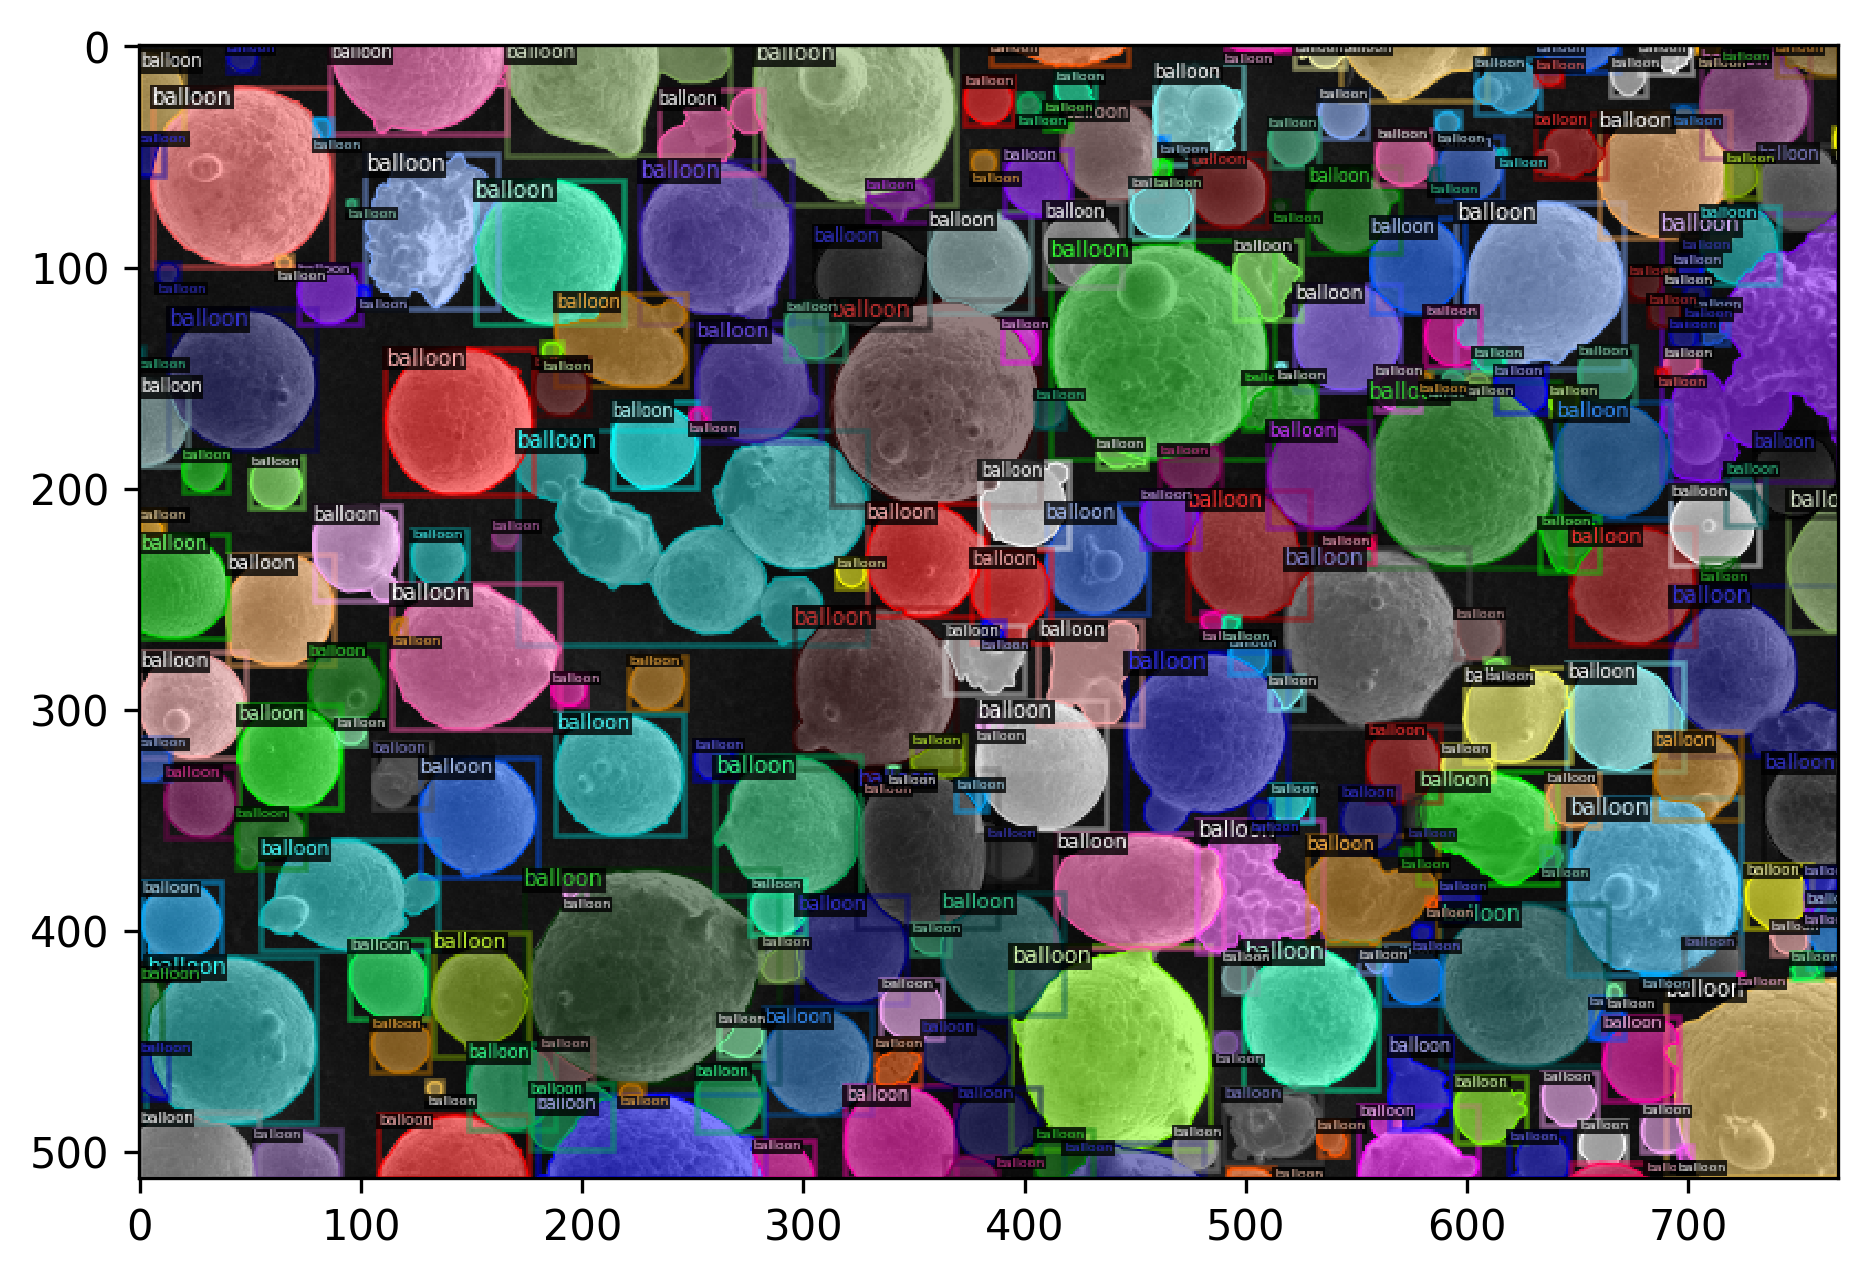

In [13]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

dataset_dicts = get_data_dicts("../data/raw/via_2.0.8/via_powder_particle_masks.json")
for d in dataset_dicts[:3]:
    img = cv2.imread(str(d["file_name"]))
    visualizer = Visualizer(img, metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    fig, ax = plt.subplots(figsize=(10,5), dpi=300)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()